# Idea
The idea is that we predict rotated linear dimension position from lines and text from the drawing.

# Thoughts
Basic logic is we split dataset to input lines or texts positions StartPoint, EndPoint, Position XYZ and predict dimension extension line poistion XLine1Point, XLine2Point XYZ.

We going to group samples by FileId. That is each sample will contain variable length data (attributes of variable number of  lines and text) and variable output data (variable number of dimensions).

I intend to [use RNN for it](https://medium.com/dair-ai/building-rnns-is-fun-with-pytorch-and-google-colab-3903ea9a3a79)

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline

In [2]:
# https://blog.floydhub.com/a-beginners-guide-on-recurrent-neural-networks-with-pytorch/
import torch
from torch import nn
from torch.utils.data import Dataset, SubsetRandomSampler
from torch.nn import functional as F

device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
    
device

/home/mk/anaconda3/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


device(type='cpu')

# Dataset implementation

In [3]:
test_data = pd.read_pickle('test_dataset.pickle')
test_data

,ClassName,FileId,XLine1Point.X,XLine1Point.Y,XLine1Point.Z,XLine2Point.X,XLine2Point.Y,XLine2Point.Z,StartPoint.X,StartPoint.Y,StartPoint.Z,EndPoint.X,EndPoint.Y,EndPoint.Z,Position.X,Position.Y,Position.Z
0,AcDbText,006cb2dd-6f18-4203-8b70-fc865c08105a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.695776,35.642180,0.0
1,AcDbText,006cb2dd-6f18-4203-8b70-fc865c08105a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.733352,10.433374,0.0
2,AcDbText,006cb2dd-6f18-4203-8b70-fc865c08105a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.733352,6.266707,0.0
3,AcDbText,006cb2dd-6f18-4203-8b70-fc865c08105a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.733352,22.584136,0.0
4,AcDbText,006cb2dd-6f18-4203-8b70-fc865c08105a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.733352,18.417470,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89231,AcDbText,09bb1674-bff4-4ac7-a86d-60a9600ce899,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.169657,92.228915,0.0
89232,AcDbLine,09bb1674-bff4-4ac7-a86d-60a9600ce899,NaN,NaN,NaN,NaN,NaN,NaN,20.2884,155.228915,0.0,0.2884,155.228915,0.0,NaN,NaN,NaN
89233,AcDbLine,09bb1674-bff4-4ac7-a86d-60a9600ce899,NaN,NaN,NaN,NaN,NaN,NaN,5.2884,145.228915,0.0,20.2884,145.228915,0.0,NaN,NaN,NaN
89234,AcDbText,09bb1674-bff4-4ac7-a86d-60a9600ce899,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,316.663400,1.478915,0.0


In [4]:
from dataset import DwgDataset
batch_size = 2

dwg_dataset = DwgDataset(pickle_file = 'test_dataset.pickle', batch_size = batch_size)

train_loader = dwg_dataset.train_loader
val_loader   = dwg_dataset.val_loader
test_loader  = dwg_dataset.test_loader

ent_features = dwg_dataset.entities.ent_features
dim_features = dwg_dataset.entities.dim_features

In [5]:
for c,d in dwg_dataset.entities:
    # print(c.shape, d.shape)
    # make sure we have every training sample not empty
    assert( c.shape[0] != 0)    

In [6]:
(a,b) = next(iter(train_loader))
print(len(a),len(b))
for (x,y) in iter(train_loader):
    for xx in x:
        print(xx.shape)
        pass
    for yy in y:
        print(yy.shape)
    # print(a.shape,b.shape)
    break

2 2
torch.Size([1617, 9])
torch.Size([4390, 9])
torch.Size([0, 6])
torch.Size([16, 6])


# Model and training


In [7]:
from model import RnnDecoder, RnnEncoder
rnn_encoder = RnnEncoder(ent_features, 1024).to(device)
rnn_decoder = RnnDecoder(1024, dim_features).to(device)

In [8]:
(x,y) = next(iter(train_loader))
print('inputs','x:',len(x),'x',x[0].shape,'y:',len(y),'x',y[0].shape)
outs_numbers, learned = rnn_encoder(x)
print('learned shape:', learned.shape)
print("outs shape:", outs_numbers.shape, 'outs_value', outs_numbers)
# make sure something is passed
outs_numbers[0] = 42
decoded = rnn_decoder(outs_numbers, learned)
print('decoded:',len(decoded),'x', decoded[0].shape)

inputs x: 2 x torch.Size([1434, 9]) y: 2 x torch.Size([73, 6])
learned shape: torch.Size([2, 1024])
outs shape: torch.Size([2, 1]) outs_value tensor([[1324],
        [  12]], dtype=torch.int32)
decoded: 2 x torch.Size([42, 6])


In [12]:
%matplotlib inline
from train import train_model, plot_history

[0-0 @ 10.1 sec] Loss: 5778.017090 Train err: 24.3%
[0-1 @ 12.5 sec] Loss: 39.953667 Train err: 0.6%
[0-2 @ 13.2 sec] Loss: 851434.187500 Train err: 0.4%
[0-3 @ 16.8 sec] Loss: 1927480.875000 Train err: 28.9%
[0-4 @ 18.4 sec] Loss: 14538.600586 Train err: 19.7%
[0-5 @ 19.0 sec] Loss: 695702.125000 Train err: 17.9%
[0-6 @ 19.4 sec] Loss: 1514648.500000 Train err: 37.4%
[0-7 @ 21.9 sec] Loss: 3554751.000000 Train err: 36.4%
[0-8 @ 23.5 sec] Loss: 936401.062500 Train err: 25.0%
[0-9 @ 25.3 sec] Loss: 774357.187500 Train err: 5.9%
[0-10 @ 25.7 sec] Loss: 419.691681 Train err: 25.3%
Epoch validation accuracy: 0.979
[1-0 @ 30.3 sec] Loss: 774357.187500 Train err: 5.9%
[1-1 @ 33.3 sec] Loss: 2623173.750000 Train err: 46.8%
[1-2 @ 34.1 sec] Loss: 9.224138 Train err: 0.0%
[1-3 @ 44.5 sec] Loss: 10968.653320 Train err: 22.9%
[1-4 @ 45.7 sec] Loss: 930433.687500 Train err: 5.2%
[1-5 @ 48.0 sec] Loss: 94238.445312 Train err: 19.4%
[1-6 @ 49.6 sec] Loss: 3474183.500000 Train err: 34.2%
[1-7 @ 50.5 

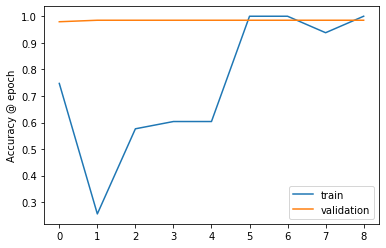

In [13]:
lr = 1e-4
epochs = 9
decoder_optimizer = torch.optim.Adam(rnn_decoder.parameters(), lr = lr)
encoder_optimizer = torch.optim.Adam(rnn_encoder.parameters(), lr = 0.1 * lr)

loss_history, train_history, val_history = train_model(
    encoder = rnn_encoder, 
    decoder = rnn_decoder, 
    train_loader = train_loader,
    val_loader = val_loader,
    loss = loss,
    decoder_opt = decoder_optimizer,
    encoder_opt = encoder_optimizer,
    epochs = epochs)

plot_history(loss_history, train_history, val_history)

In [14]:
torch.cuda.empty_cache()

rnn_encoder.eval()
rnn_decoder.eval()

(x,y) = next(iter(test_loader))
out, hidden = rnn_encoder(x)
prediction = rnn_decoder(out, hidden)

print(out)

print('predictions')
for p in prediction:
    print(p.shape)
print('actual')
for yy in y:
    print(yy.shape)

tensor([[1065],
        [ 170]], dtype=torch.int32)
predictions
torch.Size([1065, 6])
torch.Size([170, 6])
actual
torch.Size([81, 6])
torch.Size([0, 6])


In [15]:
ii = pd.DataFrame(x[0].cpu().detach().numpy())
print(ii.head())
yy = pd.DataFrame(y[0].cpu().detach().numpy())
print(len(yy))
print(yy.head())
pp = pd.DataFrame(prediction[0].cpu().detach().numpy())
print(len(pp))
print(pp.head())

     0    1    2    3    4    5          6          7    8
0  0.0  0.0  0.0  0.0  0.0  0.0  24.243427  44.084911  0.0
1  0.0  0.0  0.0  0.0  0.0  0.0  25.281004  18.876106  0.0
2  0.0  0.0  0.0  0.0  0.0  0.0  25.281004  14.709439  0.0
3  0.0  0.0  0.0  0.0  0.0  0.0  25.281004  31.026869  0.0
4  0.0  0.0  0.0  0.0  0.0  0.0  25.281004  26.860203  0.0
81
            0         1    2           3         4    5
0  514.177979  144.5215  0.0  515.439575   94.5215  0.0
1  515.439575   94.5215  0.0  514.332886   99.5215  0.0
2  507.227325   99.5215  0.0  508.432892  107.0215  0.0
3  514.159180  144.5215  0.0  515.131592  114.5215  0.0
4  508.037872  132.0215  0.0  514.276489  139.5215  0.0
1065
          0    1         2         3         4         5
0  0.999935  1.0 -0.999838  0.999300  0.999813  0.983879
1  0.999958  1.0 -0.999879  0.999788  0.999806  0.982645
2  0.999958  1.0 -0.999879  0.999788  0.999806  0.982642
3  0.999958  1.0 -0.999879  0.999788  0.999806  0.982642
4  0.999958  1.0 

In [16]:
from train import calculate_accuracy
torch.cuda.empty_cache()

rnn_encoder.eval()
rnn_decoder.eval()

test_accuracies = []
for (x,y) in test_loader:
    with torch.no_grad():
        out, hidden = rnn_encoder(x)
        prediction = rnn_decoder(out, hidden)
        accuracy = calculate_accuracy(prediction, y)
        test_accuracies.append(accuracy)
        
mean_test_accuracy = np.mean(test_accuracies)
print('Accuracy on testing: {0:2.3f}'.format(mean_test_accuracy))

Accuracy on testing: 0.900
